In [3]:
# Importing packages
import pandas as pd
import numpy  as np
import folium
import os.path
import shapely
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import IFrame
import matplotlib.patheffects as PathEffects

# Importing modules
import gr_mapmatch # Contains functions that perform the map matching of roads
import gr_placematch # Contains functions that perform the map matching of places
import gr_utils # Contains useful geometry functions
import gr_plot # Contains plotting routines
import gr_process

/Users/svanwal/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [34]:
trailname = 'gr122' # Name of the hiking trail to be considered (will search for trail.csv or trail.gpx as sources)
n1 = 0
n2 = 100

# Settings for trail2roads
points_per_batch = 100 # Subdivide the trail into batches of this many points
delta = 0.005 # Tolerance around bounding box per trail section [deg]

# Settings for roads2places
points_per_batch_places = 100 # Subdivide the trail into batches of this many segments
delta_places = 0.015 # bbox delta in deg

# Settings for places2processed
tracktype_p0 = ['grade4','grade5']
tracktype_p1 = ['grade2','grade3']
tracktype_p2 = ['grade1']
surface_p0   = ['ground','grass','dirt','sand','earth','mud']
surface_p1   = ['unpaved','gravel','fine_gravel','wood','compacted','rocks','pebblestone','woodchips','snow','ice','salt']
highway_p1   = ['track','path','footway','bridleway']
tol_d        = 0.5 # Consider a segment developed if it lies closer than tol_d to a developed area
types_slow   = ['pedestrian','track','footway','bridleway','steps','corridor','path']
types_heavy  = ['motorway','trunk','primary','secondary','tertiary']

In [35]:
trail = gr_utils.get_gpx(trailname)

Loading trail points from <data_input/gr122.gpx>...
Finished loading.


In [36]:
data_roads = gr_utils.read_roads(trailname)
bbox = gr_placematch.get_bbox(data_roads[n1:n2], delta_places);
places_landuse, places_admin8, places_admin9 = gr_placematch.get_places(bbox) # Grab relevant place information

In [7]:
def get_focus(trail):
    
    trail_coords  = gr_mapmatch.trail_to_coords(trail)
    mid = int(np.round(len(trail_coords)/2))
    return trail_coords[mid]

## Drawing all polygons

In [99]:
# Map setup
chart = folium.Map(location=get_focus(trail[n1:n2]), zoom_start=13, tiles="OpenStreetMap")

# Draw development areas
for i in range(places_landuse.shape[0]):

    item = places_landuse.iloc[i]
    x,y = item['geometry'].exterior.coords.xy
    coords = pd.DataFrame({'LAT':y,'LON':x})
    newline = folium.Polygon(locations=coords, color='blue', fill=True, fillOpacity=0.5)
    newline.add_to(chart)

# Draw trail
coords = gr_plot.get_fullcoords_from_frame(data_roads)
newline = folium.PolyLine(locations=coords[n1:n2], weight=3, color='red')
newline.add_to(chart)

# Draw bounding box
x,y = bbox.exterior.coords.xy
coords = pd.DataFrame({'LAT':y,'LON':x})
newline = folium.Polygon(locations=coords, color='black', fill=False, fillOpacity=0.2, popup=item['name'])
newline.add_to(chart)

# Render the map
filepath = f"cache/plot_all_devs.html"
chart.save(filepath)
IFrame(filepath, width=1000, height=500)

## Drawing scaled polygons

In [103]:
# Map setup
chart = folium.Map(location=get_focus(trail[n1:n2]), zoom_start=13, tiles="OpenStreetMap")

sc = 1.05

# Draw development areas
for i in range(places_landuse.shape[0]):

    item = places_landuse.iloc[i]
    item_geom = shapely.affinity.scale(item['geometry'], xfact=sc, yfact=sc, origin='center')
    x,y = item_geom.exterior.coords.xy
    coords = pd.DataFrame({'LAT':y,'LON':x})
    newline = folium.Polygon(locations=coords, color='blue', fill=True, fillOpacity=0.5)
    newline.add_to(chart)

# Draw trail
coords = gr_plot.get_fullcoords_from_frame(data_roads)
newline = folium.PolyLine(locations=coords[n1:n2], weight=3, color='red')
newline.add_to(chart)

# Draw bounding box
x,y = bbox.exterior.coords.xy
coords = pd.DataFrame({'LAT':y,'LON':x})
newline = folium.Polygon(locations=coords, color='black', fill=False, fillOpacity=0.2, popup=item['name'])
newline.add_to(chart)

# Render the map
filepath = f"cache/plot_all_devs.html"
chart.save(filepath)
IFrame(filepath, width=1000, height=500)

## Test merging nearby polygons

In [93]:
# Map setup
chart = folium.Map(location=get_focus(trail[n1:n2]), zoom_start=13, tiles="OpenStreetMap")

# Draw trail
# coords = gr_plot.get_fullcoords_from_frame(data_roads)
# newline = folium.PolyLine(locations=coords, weight=3, color='red')
# newline.add_to(chart)

# Draw bounding box
# x,y = bbox.exterior.coords.xy
# coords = pd.DataFrame({'LAT':y,'LON':x})
# newline = folium.Polygon(locations=coords, color='black', fill=False, fillOpacity=0.2, popup=item['name'])
# newline.add_to(chart)

# Draw development areas

# First scaled poly
i = 16;
item1 = places_landuse.iloc[i]
item1['geometry'] = shapely.affinity.scale(item1['geometry'], xfact=1.05, yfact=1.05, origin='center')
x,y = item1['geometry'].exterior.coords.xy
coords1 = pd.DataFrame({'LAT':y,'LON':x})

# Second scaled poly
i = 17;
item2 = places_landuse.iloc[i]
item2['geometry'] = shapely.affinity.scale(item2['geometry'], xfact=1.05, yfact=1.05, origin='center')
x,y = item2['geometry'].exterior.coords.xy
coords2 = pd.DataFrame({'LAT':y,'LON':x})

# Merged poly
item3 = unary_union([item1['geometry'],item2['geometry']])
x,y = item3.exterior.coords.xy
coords3 = pd.DataFrame({'LAT':y,'LON':x})

# Adding to map
newline = folium.Polygon(locations=coords3, color='black', fill=True, fillOpacity=5)
newline.add_to(chart)
# newline = folium.Polygon(locations=coords1, color='red', fill=False)
# newline.add_to(chart)
# newline = folium.Polygon(locations=coords2, color='blue', fill=False)
# newline.add_to(chart)

# Render the map
filepath = f"cache/plot_developents.html"
chart.save(filepath)
IFrame(filepath, width=1000, height=500)

/var/folders/zh/x06gqp657rl9h1shq_pn7gjh0000gn/T/ipykernel_9957/3899819261.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item1['geometry'] = shapely.affinity.scale(item1['geometry'], xfact=1.05, yfact=1.05, origin='center')
/var/folders/zh/x06gqp657rl9h1shq_pn7gjh0000gn/T/ipykernel_9957/3899819261.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item2['geometry'] = shapely.affinity.scale(item2['geometry'], xfact=1.05, yfact=1.05, origin='center')


In [75]:
from shapely.ops import unary_union
test = unary_union([item1['geometry'],item2['geometry']])

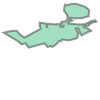

In [76]:
test

In [61]:
temp = shapely.affinity.scale(item2['geometry'], xfact=1.5, yfact=1.5, origin='center')

In [37]:
def joinPolygons(polya, polyb):
    """
    Generate and return a single connected polygon which includes the two given
    polygons. The connection between the two polygons is based on the convex hull
    of the composite polygon. All polygons are sequences of two-tuples giving the
    vertices of the polygon as (x, y), in order. That means vertices that are adjacent
    in the sequence are adjacent in the polygon (connected by an edge). The first and
    last vertices in the sequence are also connected by any edge (implicitly closed, do
    not duplicate the first point at the end of the sequence to close it).

    Only simple polygons are supported (no self-intersection).
    """

    #Just to make it easier to identify and access by index.
    polygons = [polya, polyb]

    #Create a single list of points to create the convex hull for (each
    # point is a vertex of one of the polygons).
    #Additionally, each point includes some additional "cargo", indicating which
    # polygon it's from, and it's index into that polygon
    # This assumes the implementation of convexHull simply ignores everything
    # beyond the first two elements of each vertex.
    composite = []
    for i in range(len(polygons)):
        points = polygons[i]
        composite += [(points[j][0], points[j][1], j, i) for j in xrange(len(points))]

    #Get the convex hull of the two polygons together.
    ch = convexHull(composite)

    #Now we're going to walk along the convex hull and find edges that connect two vertices
    # from the same source polygon. We then replace that edge with all the intervening edges
    # from that source polygon.

    #Start with the first vertex in the CH.
    x, y, last_vnum, last_pnum = ch[0]

    #Here is where we will collect the vertices for our resulting polygon, starting with the
    # first vertex on the CH (all the vertices on the CH will end up in the result, plus some
    # additional vertices from the original polygons).
    results = [(x, y)]

    #The vertices of the convex hull will always walk in a particular direction around each
    # polygon (i.e., forwards in the sequence of vertices, or backwards). We will use this
    # to keep track of which way they go.
    directions = [None for poly in polygons]

    #Iterate over all the remaining points in the CH, and then back to the first point to
    # close it.
    for x, y, vnum, pnum in list(ch[1:]) + [ch[0]]:

        #If this vertex came from the same original polygon as the last one, we need to
        # replace the edge between them with all the intervening edges from that polygon.
        if pnum == last_pnum:

            #Number of vertices in the polygon
            vcount = len(polygons[pnum])

            #If an edge of the convex hull connects the first and last vertex of the polygon,
            # then the CH edge must also be an edge of the polygon, because the two vertices are
            # adjacent in the original polygon. Therefore, if the convex
            # hull goes from the first vertex to the last in a single edge, then it's walking
            # backwards around the polygon. Likewise, if it goes from the last to the first in 
            # a single edge, it's walking forwards.
            if directions[pnum] is None:
                if last_vnum < vnum:
                    if last_vnum == 0 and vnum == vcount - 1:
                        direction = -1
                    else:
                        direction = 1
                else:
                    if last_vnum == vcount - 1 and vnum == 0:
                        direction = 1
                    else:
                        direction = -1
                directions[pnum] = direction
            else:
                direction = directions[pnum]

            #Now walk from the previous vertex to the current one on the source
            # polygon, and add all the intevening vertices (as well as the current one
            # from the CH) onto the result.
            v = last_vnum
            while v != vnum:
                v += direction
                if v >= vcount:
                    v = 0
                elif v == -1:
                    v = vcount - 1
                results.append(polygons[pnum][v])

        #This vertex on the CH is from a different polygon originally than the previous
        # vertex, so we just leave them connected.
        else:
            results.append((x, y))

        #Remember this vertex for next time.
        last_vnum = vnum
        last_pnum = pnum

    return results



def convexHull(points, leftMostVert=None):
    """
    Returns a new polygon which is the convex hull of the given polygon.

    :param: leftMostVert    The index into points of the left most vertex in the polygon.
                            If you don't know what it is, pass None and we will figure it
                            out ourselves.
    """
    point_count = len(points)

    #This is implemented using the simple Jarvis march "gift wrapping" algorithm.
    # Generically, to find the next point on the convex hull, we find the point
    # which has the smallest clockwise-angle from the previous edge, around the
    # last point. We start with the left-most point and a virtual vertical edge
    # leading to it.

    #If the left-most vertex wasn't specified, find it ourselves.
    if leftMostVert is None:
        minx = points[0][0]
        leftMostVert = 0
        for i in xrange(1, point_count):
            x = points[i][0]
            if x < minx:
                minx = x
                leftMostVert = i

    #This is where we will build up the vertices we want to include in the hull.
    # They are stored as indices into the sequence `points`.
    sel_verts = [leftMostVert]

    #This is information we need about the "last point" and "last edge" in order to find
    # the next point. We start with the left-most point and a pretend vertical edge.

    #The index into `points` of the last point.
    sidx = leftMostVert

    #The actual coordinates (x,y) of the last point.
    spt = points[sidx]

    #The vector of the previous edge.
    # Vectors are joined tail to tail to measure angle, so it
    # starts at the last point and points towards the previous point.
    last_vect = (0, -1, 0)
    last_mag = 1.0

    #Constant
    twopi = 2.0*math.pi

    #A range object to iterate over the vertex numbers.
    vert_nums = range(point_count)

    #A list of indices of points which have been determined to be colinear with
    # another point and a selected vertex on the CH, and which are not endpoints
    # of the line segment. These points are necessarily not vertices of the convex
    # hull: at best they are internal to one of its edges.
    colinear = []

    #Keep going till we come back around to the first (left-most) point.
    while True:
        #Try all other end points, find the one with the smallest CW angle.
        min_angle = None
        for i in vert_nums:

            #Skip the following points:
            # -The last vertex (sidx)
            # -The second to last vertex (sel_verts[-2]), that would just backtrack along
            #  the edge we just created.
            # -Any points which are determined to be colinear and internal (indices in `colinear`).
            if i == sidx or (len(sel_verts) > 1 and i == sel_verts[-2]) or i in colinear:
                continue

            #The point to test (x,y)
            pt = points[i]

            #vector from current point to test point.
            vect = (pt[0] - spt[0], pt[1] - spt[1], 0)
            mag = math.sqrt(vect[0]*vect[0] + vect[1]*vect[1])

            #Now find clockwise angle between the two vectors. Start by
            # finding the smallest angle between them, using the dot product.
            # Then use cross product and right-hand rule to determine if that
            # angle is clockwise or counter-clockwise, and adjust accordingly.

            #dot product of the two vectors.
            dp = last_vect[0]*vect[0] + last_vect[1]*vect[1]
            cos_theta = dp / (last_mag * mag)

            #Ensure fp erros don't become domain errors.
            if cos_theta > 1.0:
                cos_theta = 1.0
            elif cos_theta < -1.0:
                cos_theta = -1.0

            #Smaller of the two angles between them.
            theta = math.acos(cos_theta)

            #Take cross product of last vector by test vector.
            # Except we know that Z components in both input vectors are 0,
            # So the X and Y components of the resulting vector will be 0. Plus,
            # we only care aboue the Z component of the result.
            cpz = last_vect[0]*vect[1] - last_vect[1]*vect[0]

            #Assume initially that angle between the vectors is clock-wise.
            cwangle = theta
            #If the cross product points up out of the plane (positive Z),
            # then the angle is actually counter-clockwise.
            if cpz > 0:
                cwangle = twopi - theta

            #If this point has a smaller angle than the others we've considered,
            # choose it as the new candidate.
            if min_angle is None or cwangle < min_angle:
                min_angle = cwangle
                next_vert = i
                next_mvect = vect
                next_mag = mag
                next_pt = pt

            #If the angles are the same, then they are colinear with the last vertex. We want
            # to pick the one which is furthest from the vertex, and put all other colinear points
            # into the list so we can skip them in the future (this isn't just an optimization, it
            # appears to be necessary, otherwise we will pick one of the other colinear points as
            # the next vertex, which is incorrect).
            #Note: This is fine even if this turns out to be the next edge of the CH (i.e., we find
            # a point with a smaller angle): any point with is internal-colinear will not be a vertex
            # of the CH.
            elif cwangle == min_angle:
                if mag > next_mag:
                    #This one is further from the last vertex, so keep it as the candidate, and put the
                    # other colinear point in the list.
                    colinear.append(next_vert)
                    min_angle = cwangle
                    next_vert = i
                    next_mvect = vect
                    next_mag = mag
                    next_pt = pt
                else:
                    #This one is closer to the last vertex than the current candidate, so just keep that
                    # as the candidate, and put this in the list.
                    colinear.append(i)

        #We've found the next vertex on the CH.
        # If it's the first vertex again, then we're done.
        if next_vert == leftMostVert:
            break
        else:
            #Otherwise, add it to the list of vertices, and mark it as the
            # last vertex.
            sel_verts.append(next_vert)
            sidx = next_vert
            spt = next_pt
            last_vect = (-next_mvect[0], -next_mvect[1])
            last_mag = next_mag

    #Now we have a list of vertices into points, but we really want a list of points, so
    # create that and return it.
    return tuple(points[i] for i in sel_verts)
